In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv("../data/train.csv")
test=pd.read_csv("../data/test.csv")

In [3]:
data.head(10)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
5,5,15771669,Genovese,588,Germany,Male,36.0,4,131778.58,1,1.0,0.0,136024.31,1
6,6,15692819,Ch'ang,593,France,Female,30.0,8,144772.69,1,1.0,0.0,29792.11,0
7,7,15669611,Chukwuebuka,678,Spain,Male,37.0,1,138476.41,1,1.0,0.0,106851.60,0
8,8,15691707,Manna,676,France,Male,43.0,4,0.00,2,1.0,0.0,142917.13,0
9,9,15591721,Cattaneo,583,Germany,Male,40.0,4,81274.33,1,1.0,1.0,170843.07,0


In [4]:
test_final=test["id"]

In [5]:
def clean(data):
    data=data.drop(["id","CustomerId","Surname"],axis=1)
    
    floatcols=["Age","HasCrCard","IsActiveMember","Balance","EstimatedSalary"]
    data[floatcols]=data[floatcols].astype('int64')

    return data

In [6]:
data=clean(data)
test=clean(test)

In [7]:
data["ActiveCrCard"]=data["HasCrCard"]*data["IsActiveMember"]

In [8]:
data.head(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,ActiveCrCard
0,668,France,Male,33,3,0,2,1,0,181449,0,0
1,627,France,Male,33,1,0,2,1,1,49503,0,1
2,678,France,Male,40,10,0,2,1,0,184866,0,0
3,581,France,Male,34,2,148882,1,1,1,84560,0,1
4,716,Spain,Male,33,5,0,2,1,1,15068,0,1
5,588,Germany,Male,36,4,131778,1,1,0,136024,1,0
6,593,France,Female,30,8,144772,1,1,0,29792,0,0
7,678,Spain,Male,37,1,138476,1,1,0,106851,0,0
8,676,France,Male,43,4,0,2,1,0,142917,0,0
9,583,Germany,Male,40,4,81274,1,1,1,170843,0,1


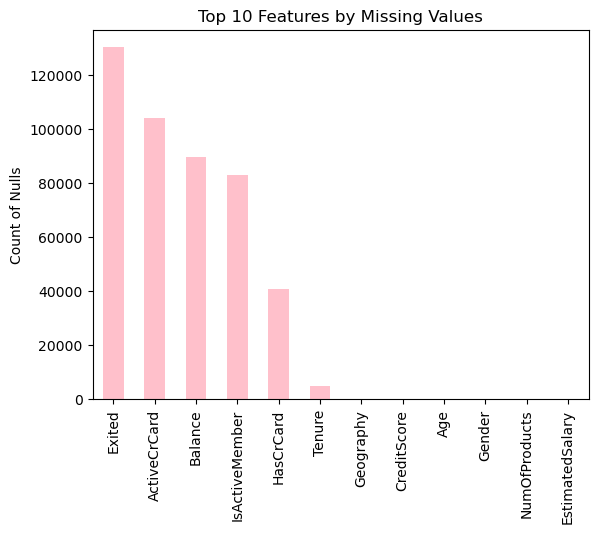

In [9]:
nulls=(data==0).sum().sort_values(ascending=False)
nulls.plot(kind='bar',color='pink')
plt.title('Top 10 Features by Missing Values')
plt.ylabel('Count of Nulls')
plt.show()

In [10]:
X=data.drop("Exited",axis=1)
y=data["Exited"]

In [11]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

catcols=["Geography","Gender"]
numcols=["Balance","IsActiveMember","HasCrCard","Tenure","CreditScore","Age","NumOfProducts","EstimatedSalary"]
interaction=numcols+["ActiveCrCard"]
interaction_only=["Balance","ActiveCrCard","Tenure","CreditScore","Age","NumOfProducts","EstimatedSalary"]

In [13]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

def make_lgb_pipeline(numcols):
    preprocess=ColumnTransformer(
    transformers=[
        ("cat",OneHotEncoder(drop="first",handle_unknown="ignore"), catcols),
        ("num","passthrough",numcols),])
    lgb=Pipeline(steps=[
        ("preprocess",preprocess),
        ("model",LGBMClassifier(verbose=-1))])

    return lgb

In [14]:
lgb_base=make_lgb_pipeline(numcols)
lgb_interaction=make_lgb_pipeline(interaction)
lgb_only_interaction=make_lgb_pipeline(interaction_only)

In [18]:
lgb.fit(X_train,y_train)
lgb_predict=lgb.predict_proba(X_test)[:,1]
lgb_auc=roc_auc_score(y_test,lgb_predict)
print("ROC AUC:",lgb_auc)

NameError: name 'lgb' is not defined

In [ ]:
from sklearn.model_selection import cross_val_score

lgbscores=cross_val_score(
    lgb,
    X,
    y,
    cv=5,
    scoring="roc_auc")

print("Fold AUCs:", lgbscores)
print("Mean AUC:",lgbscores.mean())
print("Std AUC:", lgbscores.std())

In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test,lgb_predict)
plt.show()

In [15]:
from sklearn.model_selection import cross_val_score

lgb_base_scores=cross_val_score(lgb_base,X,y,cv=5,scoring="roc_auc")
lgb_interaction_scores=cross_val_score(lgb_interaction,X,y,cv=5,scoring="roc_auc")
lgb_only_interaction_scores=cross_val_score(lgb_only_interaction,X,y,cv=5,scoring="roc_auc")

print("Base:",lgb_base_scores.mean(),lgb_base_scores.std())
print("Interaction:",lgb_interaction_scores.mean(),lgb_interaction_scores.std())
print("Interaction only:",lgb_only_interaction_scores.mean(),lgb_only_interaction_scores.std())

/Users/maudq/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/maudq/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/maudq/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/maudq/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/maudq/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with f

Base: 0.8894680151631291 0.001655222687655472
Interaction: 0.8893600629121856 0.0018019430587193352
Interaction only: 0.8854473988423852 0.0016849707118926408


/Users/maudq/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [16]:
from catboost import CatBoostClassifier

cbm=CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    depth=6,
    learning_rate=0.05,
    iterations=1000,
    verbose=False)

cbm.fit(X_train,y_train,cat_features=catcols,eval_set=(X_test,y_test))
cbm_predict=cbm.predict_proba(X_test)[:,1]
cbm_auc=roc_auc_score(y_test,cbm_predict)
print("ROC AUC:",cbm_auc)

ROC AUC: 0.8916082147489569


In [ ]:
cbm_scores=cross_val_score(cbm,X,y,cv=5,scoring="roc_auc",fit_params={"cat_features":catcols})

print("ROC:",cbm_scores.mean(),cbm_scores.std())

In [23]:
from sklearn.ensemble import VotingClassifier

ensemble=VotingClassifier(
    estimators=[
        ("lgb",lgb_base),
        ("cat",cbm)],
    voting="soft",
    weights=[0.5,0.5])

ensemble.fit(X_train,y_train)
ensemble_prediction=ensemble.predict_proba(X_test)[:,1]
ensemble_auc=roc_auc_score(y_test,ensemble_prediction)
print("Ensemble AUC:",ensemble_auc)

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=1]="France": Cannot convert 'France' to float